In [36]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


First we load the dataset from the Github


In [37]:
# Load the dataset
url = "https://github.com/robertasgabrys/DSO424Fall2023/raw/main/CompetitionData.xlsx"
df = pd.read_excel(url)


We then checked the dimensions of the dataset

In [38]:
# Check the dimensions of the DataFrame
dimensions = df.shape
print(dimensions)


(43824, 5)


In [39]:
summary_stats = df.describe()
print(summary_stats)


               Tavg          Tmed          Tmax          Tmin          Load
count  43824.000000  43824.000000  43824.000000  43824.000000  3.506400e+04
mean      69.662765     70.354783     77.627921     62.071878  1.344426e+06
std       11.981578     12.035757     10.231958     13.926798  4.255054e+05
min       24.000000     25.000000     34.000000     16.000000  4.929070e+05
25%       62.000000     63.000000     72.000000     52.000000  1.036139e+06
50%       72.000000     73.000000     79.000000     65.000000  1.250392e+06
75%       78.000000     79.000000     85.000000     73.000000  1.618791e+06
max       94.000000     95.000000    100.000000     90.000000  3.109786e+06


Check for missing data



In [40]:
# Check for missing values in the DataFrame
missing_values = df.isnull().sum()
print(missing_values)


Tavg       0
Tmed       0
Tmax       0
Tmin       0
Load    8760
dtype: int64


The load column had 8760 missing observations



Drop the missing values


In [41]:
# Drop rows with missing 'Load' values
df_cleaned = df.dropna(subset=['Load'])
df_cleaned

,Tavg,Tmed,Tmax,Tmin,Load
0,43,43.0,60.0,31.0,1384494.0
1,42,42.0,58.0,29.0,1392822.0
2,41,41.0,57.0,31.0,1407887.0
3,41,41.0,56.0,30.0,1438658.0
4,40,41.0,53.0,29.0,1484046.0
...,...,...,...,...,...
35059,64,64.0,70.0,60.0,1409813.0
35060,62,63.0,68.0,57.0,1309493.0
35061,61,62.0,67.0,57.0,1217706.0
35062,61,61.0,67.0,55.0,1127940.0


We dropped the  rows with missing values

Since our data had no datetime column ,we created one,we generated it based on hourly frequency

In [42]:
# the data doesn't have a datetime column
# Generate a time variable based on hourly frequency
df_cleaned['Time'] = pd.date_range(start="2003-01-01 00:00:00", periods=len(df_cleaned), freq="H")




C:\Users\HP\AppData\Local\Temp\ipykernel_12656\1948045949.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Time'] = pd.date_range(start="2003-01-01 00:00:00", periods=len(df_cleaned), freq="H")


We then sorted values by time 


In [43]:
df_sorted = df_cleaned.sort_values(by='Time')

# Display the sorted DataFrame
print(df_sorted.head())  # Display the first few rows to verify the sorting

   Tavg  Tmed  Tmax  Tmin       Load                Time
0    43  43.0  60.0  31.0  1384494.0 2003-01-01 00:00:00
1    42  42.0  58.0  29.0  1392822.0 2003-01-01 01:00:00
2    41  41.0  57.0  31.0  1407887.0 2003-01-01 02:00:00
3    41  41.0  56.0  30.0  1438658.0 2003-01-01 03:00:00
4    40  41.0  53.0  29.0  1484046.0 2003-01-01 04:00:00


Let's start with the exploratory data analysis (EDA) to identify seasonality patterns in our dataset.

Graph of the Entire Load Dataset (Annual Seasonality)

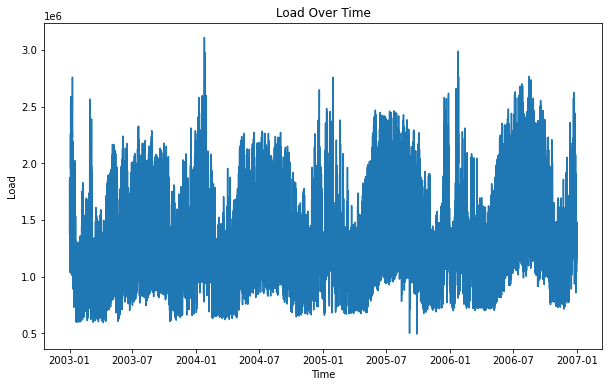

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'Time' is your time column in df_sorted
# Convert 'Time' column to datetime format
df_sorted['Time'] = pd.to_datetime(df_sorted['Time'])

# Plotting the graph again with the updated 'Time' format
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['Time'], df_sorted['Load'])
plt.xlabel('Time')
plt.ylabel('Load')
plt.title('Load Over Time')
plt.show()



The regular spikes after 6 motnths signifies trend in our dataset


For a shorter period,we can slice the dataframe to cover only a few days or weeks

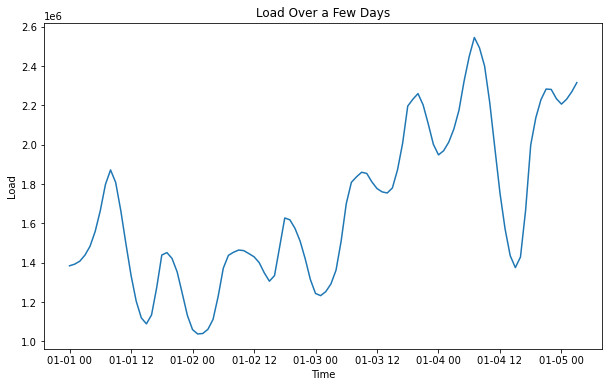

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['Time'].iloc[:100], df_sorted['Load'].iloc[:100])  # Plotting for the first 100 data points
plt.xlabel('Time')
plt.ylabel('Load')
plt.title('Load Over a Few Days')
plt.show()


From this graph their increasing trend ,Consistent rise  and fall in electricity demand within 24 hour period indicating peak hours and off peak hours shows daily seasonality


For a few weeks:

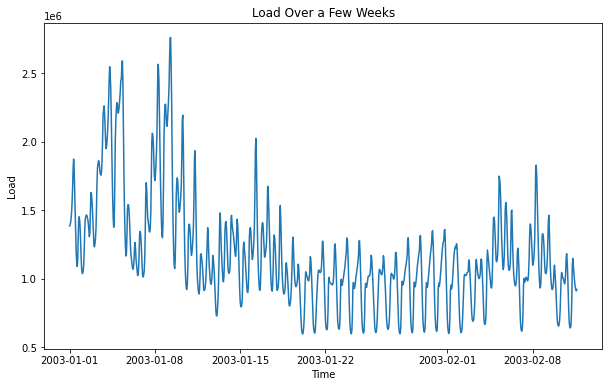

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['Time'].iloc[:1000], df_sorted['Load'].iloc[:1000])  # Plotting for the first 1000 data points
plt.xlabel('Time')
plt.ylabel('Load')
plt.title('Load Over a Few Weeks')
plt.show()

The consumption of electricity in week days is higher than the weekends 

To compare Load with Temperature:

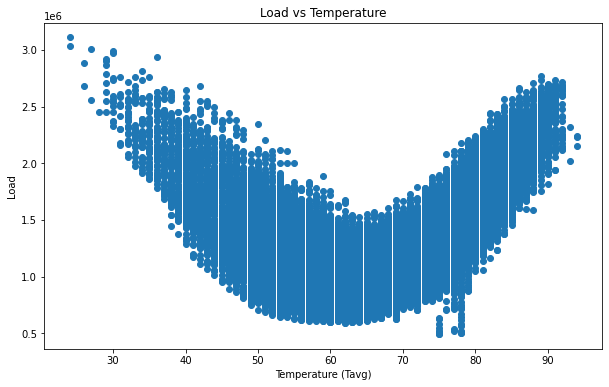

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(df_sorted['Tavg'], df_sorted['Load'])
plt.xlabel('Temperature (Tavg)')
plt.ylabel('Load')
plt.title('Load vs Temperature')
plt.show()



 As temperatures increases from 0 to 60 the load decreases ,however as  it increases  from 65, the Load also increases  forming the U-shaped pattern.
 

Trend Feature

In [48]:
df_sorted['Trend'] = range(1, len(df_sorted) + 1)


Daily Seasonality and Non linear temperature relationships


Nonlinear Temperature Relationships


In [49]:
df_sorted['Tavg_Squared'] = df_sorted['Tavg'] ** 2
df_sorted['Tavg_Cubed'] = df_sorted['Tavg'] ** 3
# Add higher orders or other transformations as needed


These transformations create new features that capture potentially nonlinear relationships between temperature and the target variable. Higher-order transformations like squares and cubes can help capture more complex patterns that might exist in the data, providing the machine learning model with additional information to make predictions. 

We created lagged values for the past 6 hours 
Lag features are crucial in time series forecasting as they capture the historical patterns and dependencies in the data. By creating lag features for the 'Load' variable for the past 6 hours ('Load_Lag_1' to 'Load_Lag_6'), the model can learn from the immediate past data. This allows it to understand how the load has changed over recent hours, which often has a direct impact on future energy consumption patterns. These lag features provide the model with valuable temporal context, enhancing its ability to make accurate predictions based on the recent history of energy load.

In [50]:
# Create lag features for the past 6 hours (adjust the range as needed)
for i in range(1, 7):
    df_sorted[f'Load_Lag_{i}'] = df_sorted['Load'].shift(i)


We then calculated the rolling mean of temperature 
The rolling mean is a method to smooth out fluctuations or noise in time series data, revealing underlying trends. Calculating the rolling mean of 'Tavg' over a 24-hour window ('Tavg_RollingMean') helps capture the average temperature trends over a day. This smoothed representation of temperature variation aids in identifying larger patterns or cycles that could influence energy consumption. By incorporating this feature, the model gains insight into the broader trends in temperature changes, which might correlate with changes in energy demand.


In [51]:
rolling_window = 24  # 24-hour window
df_sorted['Tavg_RollingMean'] = df_sorted['Tavg'].rolling(window=rolling_window).mean()


Extract date and time components (hour, day, month, etc.) from the 'Time' column to include as additional features.

Extracting date and time components such as hour, day, month, etc., from the 'Time' column allows the model to understand and incorporate temporal patterns and seasonality in energy consumption. For instance, different times of the day or specific months might exhibit varying energy demand patterns. By breaking down time into its components, the model can discern and learn from these patterns, thus improving its ability to predict load demand at different times of the day or year.

In [52]:
df_sorted['Hour'] = df_sorted['Time'].dt.hour
df_sorted['Day'] = df_sorted['Time'].dt.day
df_sorted['Month'] = df_sorted['Time'].dt.month


In summary, these feature engineering steps enrich the dataset by providing the model with relevant historical context, smoothed representations of temperature trends, and temporal components. This empowers the model to capture intricate patterns and dependencies in the data, leading to more accurate and robust long-term energy load forecasts.


Now lets Check the relationships of our variables


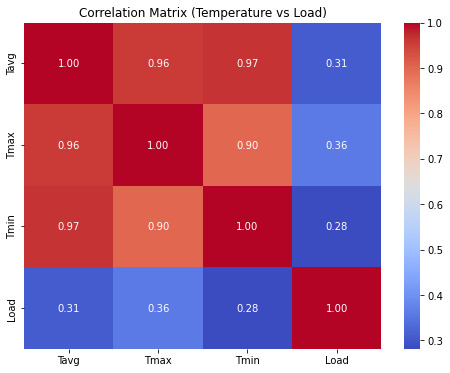

In [53]:
# Calculate correlations
correlation_matrix = df_sorted[['Tavg', 'Tmax', 'Tmin', 'Load']].corr()
correlation_matrix

# Visualize correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Temperature vs Load)')
plt.show()


These correlations highlight some degree of relationship between temperature variables (Tavg, Tmax, Tmin) and the energy load. However, the correlations are not very high, signifying that other factors beyond temperature might also play significant roles in influencing energy demand.

In [54]:
# Lagged Temperature Features
for i in range(1, 7):
    df_sorted[f'Temp_Lag_{i}'] = df_sorted['Tavg'].shift(i)  # Assuming 'Tavg' is the average temperature

# Rolling Mean of Temperature
rolling_window = 24  # 24-hour window
df_sorted['Tavg_RollingMean'] = df_sorted['Tavg'].rolling(window=rolling_window).mean()

# Temperature Range
df_sorted['Temp_Range'] = df_sorted['Tmax'] - df_sorted['Tmin']


Columns like 'Temp_Lag_1' to 'Temp_Lag_6' now store temperature values from 1 to 6 hours ago.
'Tavg_RollingMean' contains the rolling average of the average temperature over a 24-hour window.
'Temp_Range' column displays the range of temperature variations within each hour (Tmax - Tmin).
These engineered features capture historical temperature trends, smoothed temperature patterns, and temperature variations over a given period. They aim to provide the model with more information to potentially improve the accuracy of load forecasting by considering different aspects of temperature behavior and their potential impact on energy demand.

Model building

In [55]:
# Selecting features and target variable
features = ['Tavg', 'Tmed', 'Tmax', 'Tmin']
target = 'Load'

These selected features will be used to train a machine learning model to predict the 'Load' column (electricity load) based on the given temperature variables ('Tavg', 'Tmed', 'Tmax', 'Tmin').

In [56]:
# Split the data into training and testing sets
train_size = int(len(df_sorted) * 0.8)
train, test = df_sorted[:train_size], df_sorted[train_size:]

This is an ensemble learning method that constructs multiple decision trees during training and outputs the average prediction of the individual trees. It's effective for regression tasks like predicting continuous values.

In [57]:
# Model Training
model = RandomForestRegressor(random_state=42)
model.fit(train[features], train[target])

RandomForestRegressor(random_state=42)

In [58]:
# Model Prediction
predictions = model.predict(test[features])
predictions

array([1120438.12320238, 1006432.89280952, 1036856.88203932, ...,
        820776.7845    ,  860803.69597619,  875830.21976786])

In [59]:
# Model Evaluation
mae = mean_absolute_error(test[target], predictions)
mape = mean_absolute_percentage_error(test[target], predictions)

In [60]:
# Print metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Mean Absolute Error (MAE): 210094.0504391574
Mean Absolute Percentage Error (MAPE): 0.14644699446319323


Weather Influence: Leverage temperature data's impact on electricity consumption for improved forecasts.

In [61]:
# Check for missing values
print(df_sorted.isnull().sum())

# Handle missing values (replace NaNs with mean for simplicity)
df_sorted.fillna(df_sorted.mean(), inplace=True)

# Define features and target variable
features = ['Tavg', 'Tmax', 'Tmin', 'Temp_Lag_1', 'Temp_Lag_2', 'Load_Lag_1', 'Load_Lag_2']
target = 'Load'

# Splitting the data into training and testing sets
train_size = int(len(df_sorted) * 0.8)
train, test = df_sorted[:train_size], df_sorted[train_size:]

# Model Training
model = RandomForestRegressor(random_state=42)
model.fit(train[features], train[target])

# Model Prediction and Evaluation
prediction2 = model.predict(test[features])

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(test[target], predictions)
mape = mean_absolute_percentage_error(test[target], predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')


Tavg                 0
Tmed                 0
Tmax                 0
Tmin                 0
Load                 0
Time                 0
Trend                0
Tavg_Squared         0
Tavg_Cubed           0
Load_Lag_1           1
Load_Lag_2           2
Load_Lag_3           3
Load_Lag_4           4
Load_Lag_5           5
Load_Lag_6           6
Tavg_RollingMean    23
Hour                 0
Day                  0
Month                0
Temp_Lag_1           1
Temp_Lag_2           2
Temp_Lag_3           3
Temp_Lag_4           4
Temp_Lag_5           5
Temp_Lag_6           6
Temp_Range           0
dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_12656\2776923908.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_sorted.fillna(df_sorted.mean(), inplace=True)


Mean Absolute Error (MAE): 210094.0504391574
Mean Absolute Percentage Error (MAPE): 0.14644699446319323


Exporting the Predictions

In [62]:
import os

# Assuming 'predictions' contains the forecasted load values
# Create a DataFrame for predictions with corresponding timestamps
submission_df = pd.DataFrame({'Time': test['Time'], 'Predicted_Load': prediction2})

# Define the file path to the Downloads directory
prediction2_path = os.path.join(os.path.expanduser("~"), "Desktop", "CompetitionSubmissionTemplate.xlsx")

# Save the predictions to the Downloads directory
submission_df.to_excel(prediction2_path, index=False)


# Define features and target variable
features = ['Tavg', 'Tmax', 'Tmin', 'Temp_Lag_1', 'Temp_Lag_2', 'Load_Lag_1', 'Load_Lag_2']
target = 'Load'

# Splitting the data into training and testing sets (for 2005 and 2006)
train = df_sorted[df_sorted['Time'].dt.year < 2006]
test = df_sorted[df_sorted['Time'].dt.year == 2006]

# Model Training
model = RandomForestRegressor(random_state=42)
model.fit(train[features], train[target])

# Model Prediction for 2006
predictions_2006 = model.predict(test[features])

# Evaluation of 2006 predictions
mae_2006 = mean_absolute_error(test[target], predictions_2006)
mape_2006 = mean_absolute_percentage_error(test[target], predictions_2006)

print(f'Mean Absolute Error (MAE) for 2006: {mae_2006}')
print(f'Mean Absolute Percentage Error (MAPE) for 2006: {mape_2006}')
